# Demo: Basic Introduction to the Density Method for Adaptive Mesh Movement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg
import scipy.linalg
import time
import sys

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In this demo, we learn how to apply **adaptive mesh movement (AMM)** to take a (possibly non-uniform) mesh of given size $N$ and automatically transform it into a new mesh that is better suited to a specfic problem. This transformation is accomplished by simulating a special **gradient flow** that moves the density of mesh points towards a quasi-optimal state. To keep things as simple as possible, the "specific problem" we examine today is the approximation of a function $u(x)\colon[-1,1]\rightarrow \mathbb{R}$ which undergoes a rapid but still smooth change near $x=0$. In future demos, we'll investigate adaptive mesh movement for improving solutions to ODEs and both elliptic and evolutionary PDEs. 

## Suggested References
- Uri M. Ascher, Robert M. M. Mattheij, and Robert D. Russell, *Numerical Solution of Boundary Value Problems for Ordinary Differential Equations*, Prentice Hall, 1988 (especially chapter 9)

- Weizhang Huang and Robert D. Russell, *Adaptive Moving Mesh Methods*, Springer, 2011

## Theory

### The Main Question

Let's focus on the easy problem of approximating a smooth function $u(x)\colon [a,b]\rightarrow \mathbb{R}$ using its samples at $N$ mesh points $\left\{x_{j}\right\}_{j=0}^{N-1}$ (so that $x_0 =a$ and $x_{N-1}=b$). Clearly, the samples will reflect the behaviour of $u(x)$ better if our mesh points are close together in regions where $u(x)$ undergoes rapid change. Conversely, if $u(x)$ is nearly constant on some subinterval of $[-1,1]$, then we can get away with only placing a few grid points in that subinterval. The central question of AMM is "how can we automatically move the $x_{j}$'s to obtain a new mesh with the desired properties?"

A remark: in AMM, we assume that $N$ is the highest number of mesh points we are willing to use. This is in contrast to the alternative method of **adaptive mesh refinement (AMR)**, where one automatically subdivides coarse grid cells into finer subgrids if the desired accuracy has not been obtained. So, in AMR, $N$ can actually increase, but only locally. 

### The Mesh Density Function

Answering the central question of AMM starts by defining a continuous **mesh density function** 
$$
\rho\colon[a,b]\rightarrow (0,\infty).
$$
For technical reasons, we must also assume there exists $\delta>0$ such that $\rho(x)>\delta$ for all $x\in [a,b]$. Think of $\rho(x)$ as encoding how grid points ought to be distributed: if $\rho(x)$ is very large in a certain region, there should be many grid points there. In practice, $\rho(x)$ must be chosen using the function $u(x)$ we seek to approximate. Really, $\rho(x)$ should increase with $|u_{x}(x)|$, since we want to place more grid points in regions of rapid change in $u(x)$. A popular choice of $\rho(x)$ in practice is the **arclength function** 
$$
\rho(x) = \langle u_{x}(x) \rangle. 
$$
where $\langle z\rangle^2 = 1+z^2$ defines the **Japanese bracket**, which acts like a smoother variant of the absolute value function. There are other fine (actually, better!) choices of $\rho(x)$ using $u_{x}$ and $u_{xx}$, but for today we'll find the arclength function gives perfectly decent results. There are also poorer choices of $\rho(x)$, such as $\rho\equiv 1$ which corresponds to a uniform mesh.  

Note also that $\rho(x)$ does not have to be a probability density: its integral over $[a,b]$ is *a priori* unrestricted. 

Finally, in some literature, the authors deal with the **monitor function** $\rho^2(x)$ instead of $\rho(x)$ itself. 

### Equidistribution of Grid Points

Now that we have a way to quantify how grid points should be distributed across $[a,b]$ using the density function, let's describe what we mean by an "optimal" mesh. 

**Definition**

Given $N>1$ and a mesh density function $\rho(x)$, we say that a mesh $\left\{x_{j}\right\}_{j=0}^{N-1}$ is **$\rho$-equidistributing** if, for all $j,k \in 0,..., N-1$, we have 
$$ 
\int_{x_{j}}^{x_{j+1}} \rho(x) \ \mathrm{d}x = \int_{x_{k}}^{x_{k+1}} \rho(x) \ \mathrm{d}x.
$$

**Pen-and-Paper Exercise**

Prove that, given a mesh density function $\rho(x)$ and $N>1$, there exists a unique $\rho$-equidistributing mesh. *Hint*: consider the mass function $m(y) = \int_{a}^{y}\rho(x) \ \mathrm{d} x.$

In other words, an equidistributing mesh puts the same amount of "mesh mass" (distributed with density $\rho(x)$) in every grid cell. Thus, grid cells where $\rho(x)\gg 1$ will be very small and grid cells where $\rho(x)\ll 1$ will be enormous. Again, this is precisely what we wanted for our problem! We can therefore quantitatively recast the main question of AMM as asking how to efficiently approximate the equidistributing mesh corresponding to our chosen $\rho(x)$ (which itself depends on the function $u(x)$).  

### Computing the Equidistributing Mesh: Continuous Perspective

In AMM, we always assume that our mesh $\left\{x_{j}\right\}_{j=0}^{N-1}$ is the image of a uniform mesh 
$$
\left\{\xi_{j}\right\}_{j=0}^{N-1} = \left\{\frac{j}{N-1}\right\}_{j=0}^{N-1}
$$
of $[0,1]$ under the image of a $C^{1}$ coordinate transformation 
$$
x(\xi) \colon [0,1]\rightarrow [a,b].  
$$
That is, 
$$
x_{j} = x(\xi_{j}) \quad \forall \ j= 0,...,N-1. 
$$

**Definition**

Given a mesh density function $\rho(x)$ on $[a,b]$, a $C^{1}$ coordinate transformation 
$$
x(\xi) \colon [0,1]\rightarrow [a,b] 
$$
is said to be **$\rho$-equidistributing** if 
$$
\frac{1}{\int_{a}^{b}\rho(x') \ \mathrm{d}x'}\int_{a}^{x(\xi)} \rho(x') \ \mathrm{d} x' = \xi \quad \forall \ \xi\in (0,1).  
$$

**Pen-and-Paper Exercise**

Prove that the image of a uniform mesh $\left\{\xi_{j}\right\}_{j=0}^{N-1}$ of $[0,1]$ under a $\rho$-equidistributing transformation $x(\xi)$ is a $\rho$-equidistributing mesh. 

So, computing the eqiudistributing mesh corresponding to our density reduces to finding an equidistributing change of coordinates. Finding an equidistributing transformation is as difficult as solving a nonlinear boundary-value problem, for if we differentiate both sides of the definiftion of such a transformation we discover $x(\xi)$ obeys
$$
\rho(x(\xi)) \frac{\partial x}{\partial \xi} = \int_{a}^{b}\rho(x') \ \mathrm{d} x' 
$$
subject to the boundary conditions 
$$
x(0) = a, \quad x(1) = b. 
$$
It is often more convenient to write the governing ODE as a second-order equation
$$
\frac{\partial}{\partial \xi}\left(\rho(x(\xi)) \frac{\partial x}{\partial \xi}\right) = 0. 
$$
In this form, we recognize the ODE as the Euler-Lagrange equation of the cost functional 
$$
E[x(\xi)] = \frac12 \int_{0}^{1}  \left|\rho(x(\xi)) \ \frac{\partial x}{\partial \xi}\right|^2 \ \mathrm{d} \xi. 
$$
Thus, equidistributing transformations minimize a certain cost. 

**Pen-and-Paper Exercise**

Verify the claims in the above paragraph by computing the variational derivative

$$
\frac{\delta E}{\delta x}. 
$$

In principle, the nonlinear (elliptic) BVP defining our equidistributing transformation $x(\xi)$ can be solved with a finite difference discretization, using iteration to handle the nonlinear term. However, it is a bit nicer to take a *parabolic* perspective: we replace our nonlinear iteration with the evolution of a false time variable $t$, and allow our equidistributing transformation to depend on $t$, so $x=x(\xi,t)$. The cost functional is now
$$
E[x(\xi,t)] = \frac12 \int_{0}^{1}  \left|\rho(x(\xi,t)) \ \frac{\partial x}{\partial \xi}\right|^2 \ \mathrm{d} \xi. 
$$
Ideally, we want $E[x(\xi,t)]$ to decrease as $t$ increases. In a perfect world, we could find $x(\xi,t)$ so that $E[x(\xi, t)]$ actually achieves its minimum very quickly. Thus, $\frac{\partial x}{\partial t}$ should point towards the direction (in function space) where cost is decreasing the quickest. From the calculus of variations, we know this means the following **gradient flow equation** is satisfied: 
$$ 
\frac{\partial x}{\partial t} = -\frac{\delta E}{\delta x} = \rho(x(\xi,t))\frac{\partial}{\partial \xi}\left(\rho(x(\xi,t)) \frac{\partial x}{\partial \xi}\right).
$$
In practice, one often introduces a time scale $\tau = \mathcal{O}\left(N^{-\alpha}\right)$ for some $\alpha>0$ and a normalization operator $A$ to rewrite the gradient flow equation as 
$$ 
\frac{\partial x}{\partial t} = -\frac{1}{\tau}A\left[\frac{\delta E}{\delta x}\right] = \frac{1}{\tau}A\left[\rho(x(\xi,t))\frac{\partial}{\partial \xi}\left(\rho(x(\xi,t)) \frac{\partial x}{\partial \xi}\right)\right].
$$
The simple choice $A[\phi] = \frac{1}{\rho}\phi$ gives the evolution equation known in the literatute as **moving mesh PDE #5 (MMPDE5)** (equation (2.52) in Huang & Russell):
$$
\frac{\partial x}{\partial t} = \frac{1}{\tau} \frac{\partial}{\partial \xi}\left(\rho(x(\xi,t)) \frac{\partial x}{\partial \xi}\right).  
$$
There are many other modified gradient flows suitable for AMM methods, see for instance Huang & Russell Ch.2 . Note that MMPDE5 is a nonlinear parabolic PDE that comes with BCs. Intuitively, its solution gradually relaxes to the steady-state  $x_{\text{eq}}$ satisfying
$$
 \frac{\partial}{\partial \xi}\left(\rho(x_{\text{eq}}(\xi)) \frac{\partial x_{\text{eq}}}{\partial \xi}\right) =0 
$$
which is precisely the nonlinear ODE obeyed by the equidistributing transformation! Thus, by simulating MMPDE5 for a suitably long time, we can relax an initial guess of optimal mesh to an equidistributing mesh. Since we're dealing with a parabolic equation, it must be discretized using an implicit scheme (centred in space/backward Euler in time, Crank-Nicolson, ...). 

We are now in a position to concretely state how we will automatically improve our meshes.

1. Choose $N>1$ and suppose we have an initial (WLOG, uniform) mesh $\left\{x^{(0)}_{j}\right\}_{j=0}^{N-1}$. 

2. Obtain the function samples $u\left(x^{(0)}_{j}\right)$ and use them to compute mesh density function samples $\rho\left(x^{(0)}_{j}\right)$. 

3. Choose a false time-step $\Delta t$ and step MMPDE5 forward by $\Delta t$ to obtain a new mesh $\left\{x^{(1)}_{j}\right\}_{j=0}^{N-1}$. This is achieved here using the implicit finite difference scheme 
\begin{align*}
x^{(0)}_{j} &=  - \left[r\left(\rho_{j-1}^{(0)} + \rho_{j}^{(0)}\right)\right]x^{(1)}_{j-1} + \left[1+r\left(\rho_{j-1}^{(0)} + 2\rho_{j}^{(0)}+\rho_{j+1}^{(0)}\right)\right]x^{(1)}_{j}
  - \left[r\left(\rho_{j}^{(0)} + \rho_{j+1}^{(0)}\right)\right]x^{(1)}_{j+1}
\end{align*}
where $r= \frac{\Delta t}{2\tau(N-1)^2}$ (see Huang & Russell (2.58) for this scheme applied to a modified MMPDE5). We also need to take BCs into account, but this is notationally awkward so we'll only discuss it in the actual code. 

4. If 
$$
\left\|x^{(1)}_{j} - x^{(0)}_{j}\right\|_{\ell^{\infty}} < \texttt{tol},
$$
then our initial guess was good enough and we can stop. Otherwise, re-define 
$$
x^{(0)}_{j} \rightarrow x^{(1)}_{j} \quad \forall \ j
$$
and go back to step 3. 

For rough error bounds on the quality of function approximation arising from this procedure, see $\S$ 2.4.4 of Huang & Russell. 

##  Code Example: A High-Quality Mesh for a Steep Hyperbolic Tangent

We implement the AMM framework laid out above using the function 
$$
u(x) = \tanh(Wx) \quad x\in [-1,1]
$$
with $W\gg 1$. This function is nearly constant with the exception of a smooth near-jump from $-1$ to $+1$ near $x=0$. 

Our mesh size is fixed at $N=101$. We initially use a uniform mesh on $[-1,1]$ with $N$ grid points. 

In [2]:
W = 100.

def u(x):
        
    return np.tanh(W*x)

In [3]:
# define endpoints of our domain [a,b]
a = -1
b = 1

# define number of points N we want on our mesh 
N = 101

We plot $u(x)$ on a uniform mesh with $N$ sample points, zooming in on the region of rapid change.  

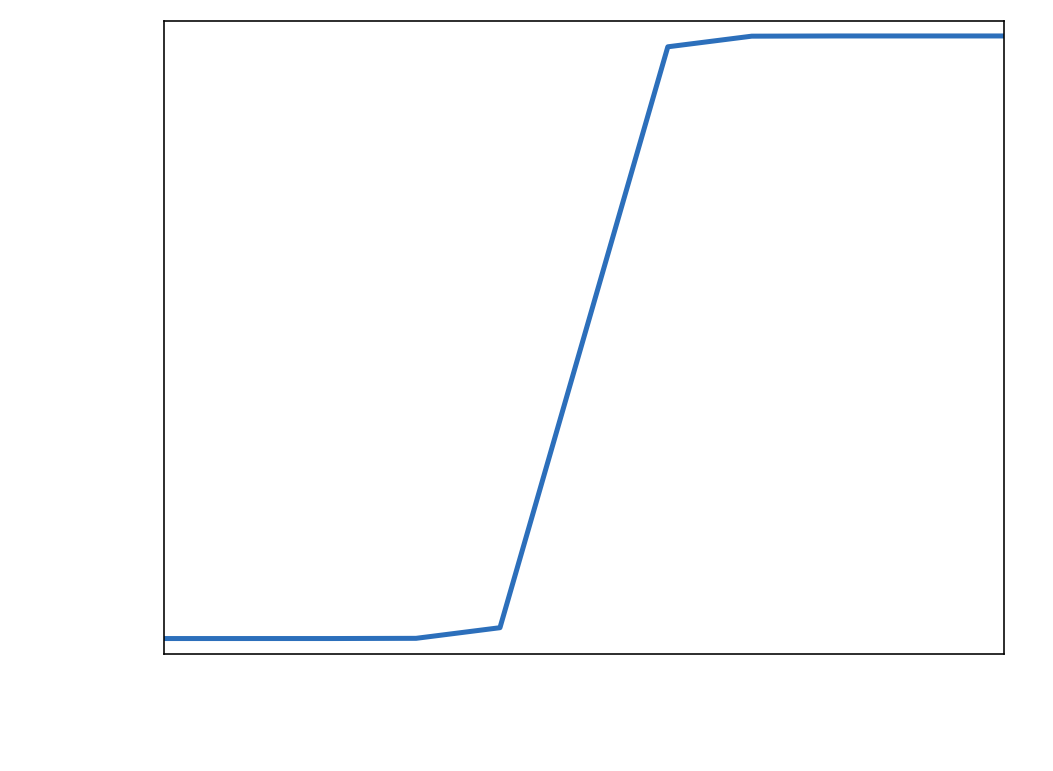

In [4]:
xx = np.linspace(a,b, N)
uu = u(xx)

fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(xx,uu, color='xkcd:medium blue',linestyle='solid' ,linewidth=2.5,)

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$u(x)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.xlim([-0.1,0.1])
plt.ylim([-1.05,1.05])

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

This picture looks a bit rough after we zoom in: there is certainly room for improvement using AMM. 

We need an automatic procedure for assembling the mesh density function, which requires the values of $u_{x}$ at the grid points. 

In [5]:
def partial_x(u,x):
# takes in a grid function {u_j} on some mesh {x_j} and spits
# out an estimate of the derivative wrt x as a mesh function

    N = np.shape(u)[0] # get grid size
    
    ux = np.zeros(N, dtype=float)
    
    """
    # finite difference approximation. TODO: this performs very poorly! 
    # Try to fix, or to implement improved estimate using Legendre polynomials 
    # as in Huang & Russell, or other accurate collocation strategy
    
    ux[0] = (u[1]-u[0])/(x[1]-x[0]) # forward difference for left endpoint x=a
            
    ux[1:] = (u[1:]-u[:-1])/(x[1:]-x[:-1]) # backward difference everywhere else
    """
    
    # Exact answer , u_{x} = W sech^2(Wx)
    ux = W*np.cosh(W*x)**-2
    
    return ux

In [6]:
def density(u,x, type = 'arclength'):
    # evaluate the mesh density function 
    
    ux = partial_x(u,x) # requires our partial_x functionality
    
    if type == 'arclength':
        
        out = np.sqrt(1.+ux**2)
        
    # TODO: include other type of mesh density function ie. the order 0 optimal one
        
    else: 
        
        raise Exception('Must specify a valid type of mesh density function')
    
    return out

Below, we plot the mesh density function evaluated at our initial, uniform grid points. 

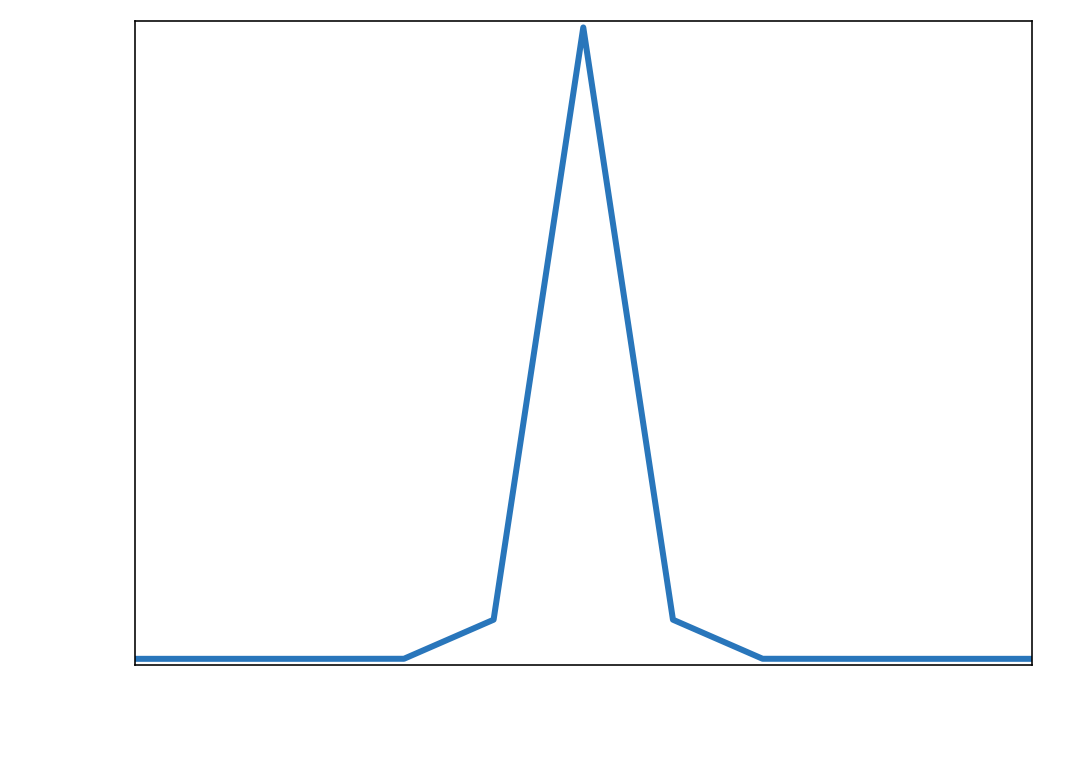

In [7]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

rho = density(uu,xx)
plt.plot(xx,rho, color='xkcd:bluish',linestyle='solid' ,linewidth=3)

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$\rho(x)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.xlim([-0.1,0.1])
plt.ylim([0,101])

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

As we expect, the density clusters near the rapid transition region, and is roughly $\equiv 1$ away from the transition region. 

We also need a routine that assembles the matrix of the linear system to be solved at each time-step. 

In [8]:
def assemble_fd_operator(u,x, dt = 0.1, tau = 0.5):
    # returns the finite difference version of the 
    # variable-coefficient operator for our gradient flow equation
    
    N = np.shape(u)[0] # get grid size
    
    M = N-2 # number of interior points
    
    r = 0.5*dt/tau/(N-1)**2
    
    # get density on old mesh
    rho = density(u,x, type = 'arclength')
    
    # Prescribe nonzero diagonals of A
    
    # MAIN DIAGONAL
    A_0 = np.zeros(N, dtype=float)
    
    A_0[1:-1] = 2.*rho[1:-1]+rho[:-2]+rho[2:]
        
    A_0 *= r

    A_0 += np.ones(N, dtype=float) # this line cleverly also takes the BCs into account!
    
    # OFF-DIAGONALS
    A_1 = np.zeros(N-1, dtype=float)
    
    A_1[1:] = rho[1:-1] + rho[2:]
    
    A_1 *= -r
    
    A_m1 = np.zeros(N-1, dtype=float)
    
    A_m1[:-1] = rho[1:-1] + rho[:-2]
    
    A_m1 *= -r
    
    # Create the sparse matrix A
    A = sparse.diags([A_0, A_1, A_m1], [0, 1, -1], shape=(N,N))
    
    A = sparse.csr_matrix(A) # make sure that A is a sparse matrix! 
    
    return A

Now, we're ready to evolve MMPDE5 and obtain better meshes. After running our parabolic mesh PDE to convergence, we plot some grid points at each time step. 

In [9]:
# initialize the mesh as a uniform grid on [a,b] of fixed size N
x_initial = np.linspace(a,b,N)
x_old = np.copy(x_initial)

# sample our function on the initial mesh
u_grid = u(x_old)

converged at iteration number 33


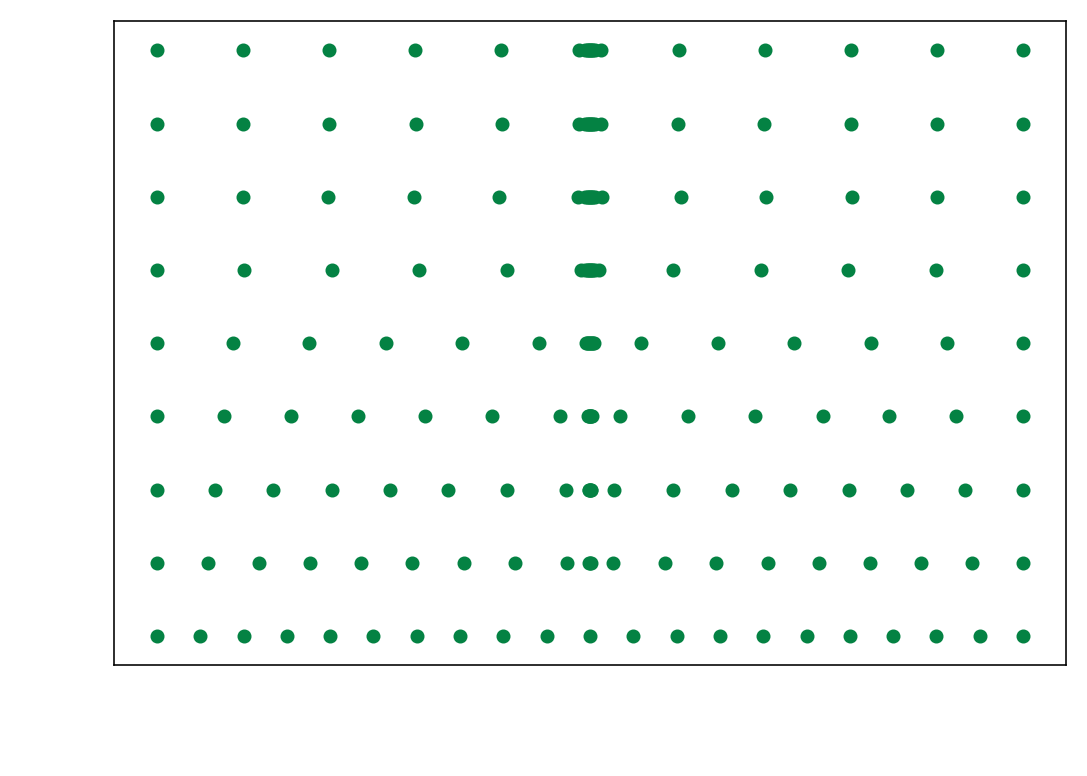

In [10]:
T = 1e2

dt = 0.1

tau = N**-4 #tau= false time scale... takes some experimentation to get right!

# initialize figure 
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x_plt = np.concatenate((x_initial[:51:5], x_initial[55::5]))

plt.plot(x_plt, np.zeros_like(x_plt), 'o', color='xkcd:jungle green')
    
for n in np.arange(0,int(T/dt)):
    
    A = assemble_fd_operator(u_grid , x_old, dt = dt, tau = tau)
    
    x_new = sparse.linalg.spsolve(A, x_old)
    
    x_new[0] = a
    
    x_new[-1] = b
    
    if np.linalg.norm(x_new-x_old, ord=np.infty)< 1e-4:
        
        print('converged at iteration number', n)
            
        break 
    
    else:
        
        x_old = x_new
        
        u_grid = u(x_old)
        
    ndump = 4
    
    if n%ndump ==0 and n>0:
        
        x_plt = np.concatenate((x_new[:51:5], x_new[55::5]))
        
        plt.plot(x_plt, n*np.ones_like(x_plt), 'o', color='xkcd:jungle green')

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"Quasi-time Step $n$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.tight_layout()

fig.set_size_inches(8, 6)
        
        
plt.show()

Again, I remind the reader that this figure shows some, not all, of the grid points. As time evolves, more grid points want to move inside the transition region, exactly as we desire! Note also that we achieve convergence in $<50$ iterations. This relatively quick convergence is accomplished by adjusting the time scale $\tau$. Additionally, the algorithm automatically senses that a uniform mesh is OK when we're far from the transition region.  

Finally, as another qualitative measure of AMM's satisfactory performance, we can plot $u(x)$ on the initial mesh and $u(x)$ on the final mesh obtained by running MMPDE5. 

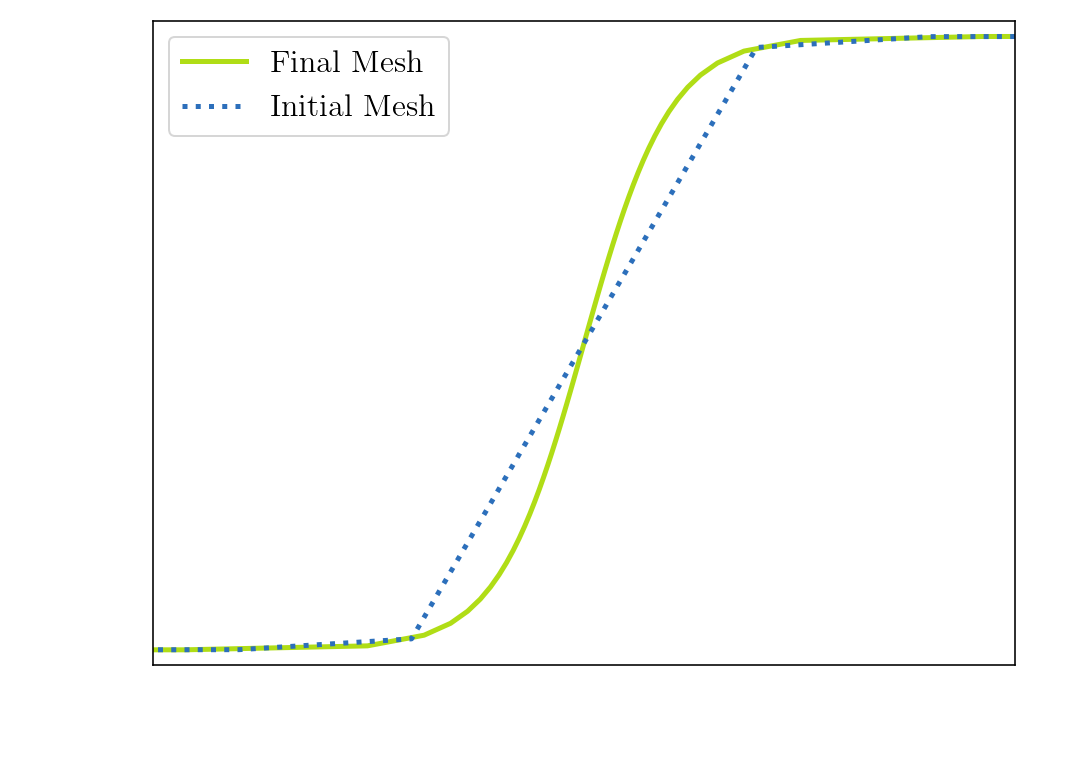

In [11]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(x_new, u(x_new), color='xkcd:yellowish green', linestyle='solid', linewidth=2.5, label='Final Mesh')
plt.plot(x_initial, u(x_initial), color='xkcd:medium blue',linestyle='dotted' ,linewidth=2.5, label='Initial Mesh')

plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$u(x)$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=16, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=16, rotation=0, color = 'w')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([-0.05,0.05])
plt.ylim([-1.05,1.05])

plt.tight_layout()

fig.set_size_inches(8, 6)

plt.show()

We find that the final mesh captures the smoothness of $u(x)$ much better than the uniform mesh. 